In [116]:
import warnings
warnings.filterwarnings('ignore')
import glob

import os
from copy import deepcopy
    
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import random

base = 'c:/Users/JCY/Dacon/shinhan/'
imp=False
def get_data(base, imp=True, ae=False):
    train_df = pd.read_csv(os.path.join(base, 'data/train.csv'))
    test_df = pd.read_csv(os.path.join(base, 'data/test.csv'))
    train_df_target_removed = train_df.drop(columns=['credit'])
    train_df_target = train_df.iloc[:, -1]

    df = pd.concat([train_df_target_removed, test_df], axis=0)

    def birth2age(x):
        return x*(-1) / 365
    df['age'] = df['DAYS_BIRTH'].apply(birth2age)
    df['skill'] = df['DAYS_EMPLOYED'].apply(birth2age)
    df['month'] = df['begin_month'].apply(lambda x: x * (-1))

    df['income_c'] = ''
    df.loc[df['income_total'] <= 1.575e6, 'income_c'] = 'first'
    df.loc[df['income_total'] <= 2.25e5, 'income_c'] ='second'
    df.loc[df['income_total'] <= 1.575e5, 'income_c'] = 'third'
    df.loc[df['income_total'] <= 1.215e5, 'income_c'] = 'fourth'

    if imp:
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Commercial associate') &\
               (df['gender'] == 'F'), 'occyp_type'] = 'Sales staff'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Commercial associate') &\
               (df['gender'] == 'F') &\
               (df['income_c'] == 'first'), 'occyp_type'] = 'Managers'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Commercial associate') &\
               (df['gender'] == 'F') &\
               (df['income_c'] == 'third') &\
               (df['work_phone'] == 1), 'occyp_type'] = 'Core staff'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Commercial associate') &\
               (df['gender'] == 'M'), 'occyp_type'] = 'Drivers'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Commercial associate') &\
               (df['gender'] == 'M') &\
               (df['income_c'] == 'first'), 'occyp_type'] = 'Managers'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Commercial associate') &\
               (df['gender'] == 'M') &\
               (df['income_c'] == 'fourth') &\
               (df['work_phone'] == 0), 'occyp_type'] = 'Laborers'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Commercial associate') &\
               (df['gender'] == 'M') &\
               (df['income_c'] == 'fourth') &\
               (df['work_phone'] == 1), 'occyp_type'] = 'Drivers'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Pensioner') &\
               (df['gender'] == 'F') &\
               (df['income_c'] == 'first') &\
               (df['work_phone'] == 0), 'occyp_type'] = 'Core staff'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'State servant'), 'occyp_type'] = 'Core staff'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'State servant') &\
               (df['gender'] == 'F') &\
               (df['income_c'] == 'first') &\
               (df['work_phone'] == 1), 'occyp_type'] = 'Managers'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'State servant') &\
               (df['gender'] == 'F') &\
               (df['income_c'] == 'second') &\
               (df['work_phone'] == 0), 'occyp_type'] = 'Medicine staff'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'State servant') &\
               (df['gender'] == 'M') &\
               (df['income_c'] == 'first') &\
               (df['work_phone'] == 1), 'occyp_type'] = 'High skill tech staff'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'State servant') &\
               (df['gender'] == 'M') &\
               (df['income_c'] == 'fouth') &\
               (df['work_phone'] == 0), 'occyp_type'] = 'Laborers'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'State servant') &\
               (df['gender'] == 'M') &\
               (df['income_c'] == 'third') &\
               (df['work_phone'] == 1), 'occyp_type'] = 'Drivers'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Working'), 'occyp_type'] = 'Laborers'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Working') &\
               (df['gender'] == 'F'), 'occyp_type'] = 'Sales staff'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'State servant') &\
               (df['gender'] == 'F') &\
               (df['income_c'] == 'first') &\
               (df['work_phone'] == 1), 'occyp_type'] = 'Managers'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'State servant') &\
               (df['gender'] == 'F') &\
               (df['income_c'] == 'second') &\
               (df['work_phone'] == 1), 'occyp_type'] = 'Core staff'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Student') &\
               (df['income_c'] == 'fourth'), 'occyp_type'] = 'Laborers'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Student') &\
               (df['income_c'] == 'second'), 'occyp_type'] = 'Core staff'
        df.loc[df['occyp_type'].isnull() &\
               (df['income_type'] == 'Pensioner'), 'occyp_type'] = 'Laborers'
    else:
        df.drop(columns=['occyp_type'], inplace=True)

    df['DAYS_BIRTH_month']=np.floor((-df['DAYS_BIRTH'])/30)-((np.floor((-df['DAYS_BIRTH'])/30)/12).astype(int)*12)
    df['DAYS_BIRTH_week']=np.floor((-df['DAYS_BIRTH'])/7)-((np.floor((-df['DAYS_BIRTH'])/7)/4).astype(int)*4)


    # DAYS_EMPLOYED
    df['DAYS_EMPLOYED_month']=np.floor((-df['DAYS_EMPLOYED'])/30)-((np.floor((-df['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
    df['DAYS_EMPLOYED_week']=np.floor((-df['DAYS_EMPLOYED'])/7)-((np.floor((-df['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

    # before_EMPLOYED
    df['before_EMPLOYED']=df['DAYS_BIRTH']-df['DAYS_EMPLOYED']
    df['before_EMPLOYED_month']=np.floor((-df['before_EMPLOYED'])/30)-((np.floor((-df['before_EMPLOYED'])/30)/12).astype(int)*12)
    df['before_EMPLOYED_week']=np.floor((-df['before_EMPLOYED'])/7)-((np.floor((-df['before_EMPLOYED'])/7)/4).astype(int)*4)

    df.drop(columns=['begin_month', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'income_c'], inplace=True)
    
    object_col = []
    for col in df.columns:
        if df[col].dtype == 'object':
            object_col.append(col)
    object_col += ['FLAG_MOBIL', 'work_phone', 'phone', 'email']
    enc = OneHotEncoder()
    enc.fit(df.loc[:,object_col])
    
    onehot_df = pd.DataFrame(enc.transform(df.loc[:,object_col]).toarray(), 
                 columns=enc.get_feature_names(object_col))

    new_df = pd.concat([df.reset_index(drop=True), onehot_df], axis=1)
    new_df.drop(columns=object_col, inplace=True)
    
    train_df = new_df[:26457]
    train_df = pd.concat([train_df, train_df_target], axis=1)  
    test_df = new_df[26457:]

    train = train_df.drop(columns=['index'])
    test = test_df.drop(columns=['index'])
    enc_list = enc.get_feature_names(object_col)
    
    
    
    if ae == True:
        enc_result = pd.read_csv('./data/encode_result.csv')
        train = pd.concat([train.drop(columns=enc_list).reset_index(drop=True),
                           enc_result[:26457].reset_index(drop=True)],
                          axis=1).reset_index(drop=True)
        test = pd.concat([test.drop(columns=enc_list).reset_index(drop=True),
                          enc_result[26457:].reset_index(drop=True)],
                         axis=1).reset_index(drop=True)
    
        print('{} features are reduced to {}-d'.format(len(enc.get_feature_names(object_col)),
                                                       len(enc_result.columns)))
    print(object_col)
    print('Shape: train {} test {} total {}'.format(train.shape, test.shape, new_df.shape))
    
    return train, train_df_target, test, new_df, enc_list

In [109]:
base = 'c:/Users/JCY/Dacon/shinhan/'
imp = True
train, train_df_target, test, new_df, enc_list = get_data(base, imp=imp, ae=True)

53 features are reduced to 11-d
['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'FLAG_MOBIL', 'work_phone', 'phone', 'email']
Shape: train (26457, 25) test (10000, 24) total (36457, 67)


In [111]:
# remove useless columns
train.drop(columns=['DAYS_BIRTH_month', 'DAYS_BIRTH_week', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week', 'before_EMPLOYED_month', 'before_EMPLOYED_week'], inplace=True)
# child_num
train.loc[(train['child_num'] == 14) | (train['child_num'] == 19), 'child_num'] = 7

In [114]:
k = 10

In [115]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))
    
random.seed(42)
lgb_models={}
scores = []
for fold in range(k):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(
        application='multiclass',
        boosting='gbdt',
        
        max_depth=17,
        num_leaves=90, #90
        min_data_in_leaf=19,  #19
        
        num_iterations=3000,
        early_stopping_rounds=30,
        learning_rate=0.01,
        
        min_sum_hessian_in_leaf=3,
        bagging_fraction=0.9,
        bagging_freq=1,
        feature_fraction=0.6,
        lambda_l2=0.7,
    )
    lgb.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], 
       verbose=100)
    lgb_models[fold]=lgb
    scores.append(lgb.best_score_['valid_1']['multi_logloss'])
    print(f'================================================================================\n\n')
print('-' * 50, 'Result', '-' * 50, '\n')
print('Mean score : {}'.format(np.mean(scores, axis=0)))
print('Variance : {}'.format(np.var(scores, axis=0)))

====================================1============================================
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's multi_logloss: 0.835003	valid_1's multi_logloss: 0.853777
[200]	valid_0's multi_logloss: 0.739742	valid_1's multi_logloss: 0.777829
[300]	valid_0's multi_logloss: 0.688925	valid_1's multi_logloss: 0.746239
[400]	valid_0's multi_logloss: 0.653214	valid_1's multi_logloss: 0.729079
[500]	valid_0's multi_logloss: 0.624514	valid_1's multi_logloss: 0.716958
[600]	valid_0's multi_logloss: 0.600096	valid_1's multi_logloss: 0.708212
[700]	valid_0's multi_logloss: 0.57823	valid_1's multi_logloss: 0.70111
[800]	valid_0's multi_logloss: 0.558683	valid_1's multi_logloss: 0.69511
[900]	valid_0's multi_logloss: 0.540807	valid_1's multi_logloss: 0.69041
[1000]	valid_0's multi_logloss: 0.524172	valid_1's multi_logloss: 0.686353
[1100]	valid_0's multi_logloss: 0.508935	valid_1's multi_logloss: 0.683499
[1200]	valid_0's multi_logloss: 0.494804	val

[500]	valid_0's multi_logloss: 0.621454	valid_1's multi_logloss: 0.739747
[600]	valid_0's multi_logloss: 0.596952	valid_1's multi_logloss: 0.732789
[700]	valid_0's multi_logloss: 0.575124	valid_1's multi_logloss: 0.727167
[800]	valid_0's multi_logloss: 0.555379	valid_1's multi_logloss: 0.72321
[900]	valid_0's multi_logloss: 0.53761	valid_1's multi_logloss: 0.719463
[1000]	valid_0's multi_logloss: 0.520769	valid_1's multi_logloss: 0.716516
[1100]	valid_0's multi_logloss: 0.505545	valid_1's multi_logloss: 0.714356
[1200]	valid_0's multi_logloss: 0.491107	valid_1's multi_logloss: 0.712762
[1300]	valid_0's multi_logloss: 0.47768	valid_1's multi_logloss: 0.71161
[1400]	valid_0's multi_logloss: 0.464911	valid_1's multi_logloss: 0.710997
Early stopping, best iteration is:
[1464]	valid_0's multi_logloss: 0.457194	valid_1's multi_logloss: 0.71064


====================================7============================================
Training until validation scores don't improve for 30 rounds.
[100

In [107]:
submit = pd.read_csv('data/sample_submission.csv')
submit.iloc[:,1:]=0
for fold in range(k):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test) / k
    
submit.to_csv('submission/lgbm/submission1.csv', index=False) 
pd.read_csv('submission/lgbm/submission1.csv')

,index,0,1,2
0,26457,0.045494,0.118442,0.836065
1,26458,0.298213,0.220759,0.481029
2,26459,0.055913,0.073407,0.870680
3,26460,0.068048,0.104187,0.827765
4,26461,0.069513,0.154438,0.776048
...,...,...,...,...
9995,36452,0.070190,0.209291,0.720519
9996,36453,0.391896,0.280614,0.327490
9997,36454,0.063655,0.081752,0.854593
9998,36455,0.179192,0.381805,0.439003


# Model list
**이전 모델들은 auto encoder 문제로 기록 x**
### 8. autoencode 11-d with imputation / 10fold
- 0.687889

### 0. autoencode 11-d with imputation / 20 fold
- 0.68395

### 1. autoencode 11-d with imputation / 50 fold
- 0.68180

### 2. useless colums removed
- 0.696380

# Auto Encoder
**w / imputation**
**기본적으로 임퓨팅하는 것이 항상 성능이 좋음**
- 10-d / 9 step / 4 layers : 0.69724
- 9-d / 9 step / 4 layers : 0.69781
- 11-d / 9 step  / 4 layers : 0.69689
- 11-d / 10 step / 4 layers : 0.69675
- 12-d / 10 step / 4 layers : 0.69885

<AxesSubplot:>

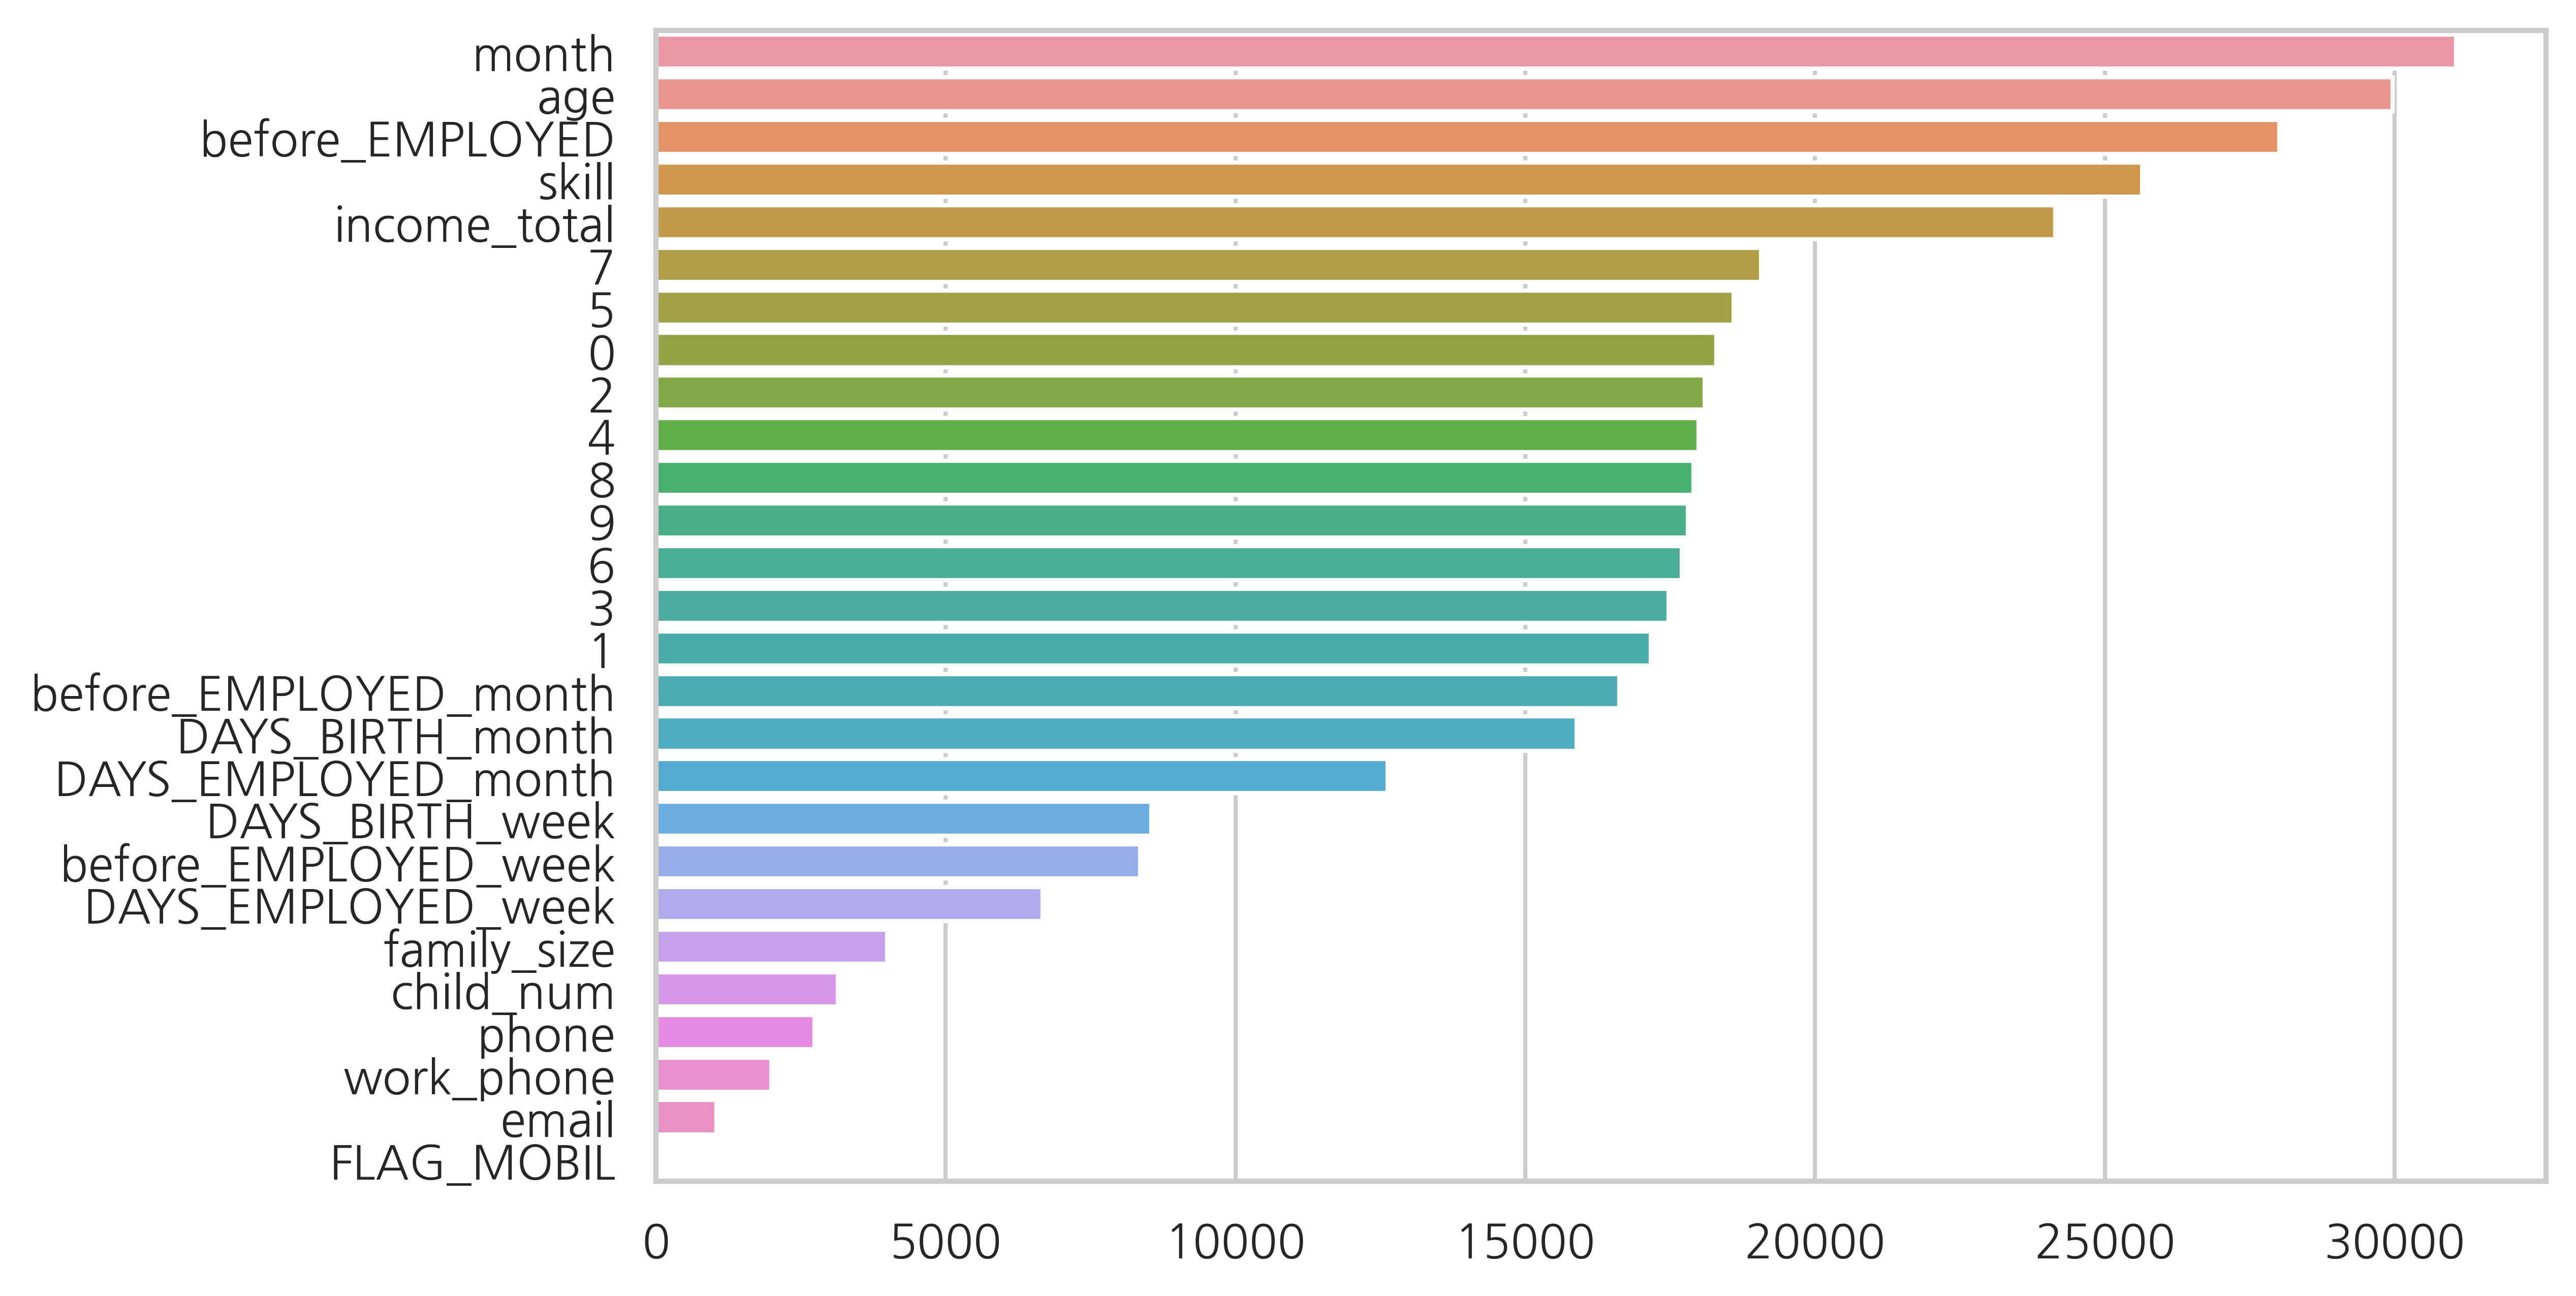

In [37]:
sns.barplot(y=test.columns[np.argsort(lgb.feature_importances_)[::-1]],
x=sorted(lgb.feature_importances_)[::-1], )

In [41]:
test

,child_num,income_total,FLAG_MOBIL,work_phone,phone,email,family_size,age,skill,month,...,0,1,2,3,4,5,6,7,8,9
0,0,112500.0,1,0,1,0,2.0,60.246575,-1000.665753,60.0,...,-0.113144,0.178755,-1.689184,-0.602926,2.140402,1.149584,-0.256939,-0.398469,-0.582084,-0.494459
1,0,135000.0,1,0,1,0,2.0,51.956164,23.756164,36.0,...,-0.421323,0.167887,-0.213144,-0.384825,-0.400360,0.189715,-0.190839,-0.239240,-0.196867,-0.438906
2,0,69372.0,1,1,1,0,2.0,43.526027,0.594521,40.0,...,-0.160902,-0.927835,0.161136,0.422088,0.827338,-0.366045,0.660056,0.002762,0.223021,-0.837451
3,0,112500.0,1,1,0,0,2.0,52.794521,6.934247,41.0,...,-0.799673,0.494677,0.128110,-0.814596,-1.086152,0.559375,-0.813365,-0.195875,0.828773,0.529585
4,0,225000.0,1,1,0,0,2.0,48.827397,25.712329,8.0,...,-0.405160,-0.178318,-0.579800,0.202778,-1.291992,0.355563,-0.825620,-0.662645,0.226575,0.545528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,202500.0,1,1,1,0,2.0,50.939726,14.887671,19.0,...,-0.219810,-0.048712,-0.212929,-0.809838,0.045789,0.312726,0.698899,0.103992,-0.897803,-0.115234
9996,0,202500.0,1,1,0,0,2.0,29.824658,3.602740,34.0,...,0.434374,0.427971,0.404807,-1.021763,-0.378854,-0.324499,-0.091803,-0.137166,-0.084699,-0.751575
9997,0,292500.0,1,0,0,0,2.0,57.578082,38.405479,55.0,...,-0.113178,-0.691725,-0.030164,0.020973,0.545517,0.069174,0.706489,0.023697,-0.321091,-0.700103
9998,0,180000.0,1,0,1,0,2.0,45.317808,2.972603,33.0,...,-0.039347,1.285148,0.603174,-0.829345,0.510743,-0.009770,-0.639630,-0.751973,1.076304,-0.358613
